# Misael Morales
## 3D Reservoir Inversion via Deep Learning
***

In [1]:
# Load my project packages
from utils_3d import *

# restart keras
import keras
keras.backend.clear_session()

In [2]:
# Check tensorflow GPU settings
check_tensorflow_gpu()

Tensorflow built with CUDA? True
Tensorflow version: 2.10.0
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
# Load all data and Visualize

In [3]:
### Load individual datasets from simulations
# satu, pres, poro, perm, facies, prod, timestamps = make_initial_data()
satu, pres, poro, perm, facies, prod, timestamps = load_initial_data()

Pres: (318, 40, 48, 48, 8) | Satu: (318, 40, 48, 48, 8)
Poro: (318, 48, 48, 8) | Perm: (318, 48, 48, 8) | Facies: (318, 48, 48, 8)
Timestamps: (40,) | Production: (318, 40, 9, 4)


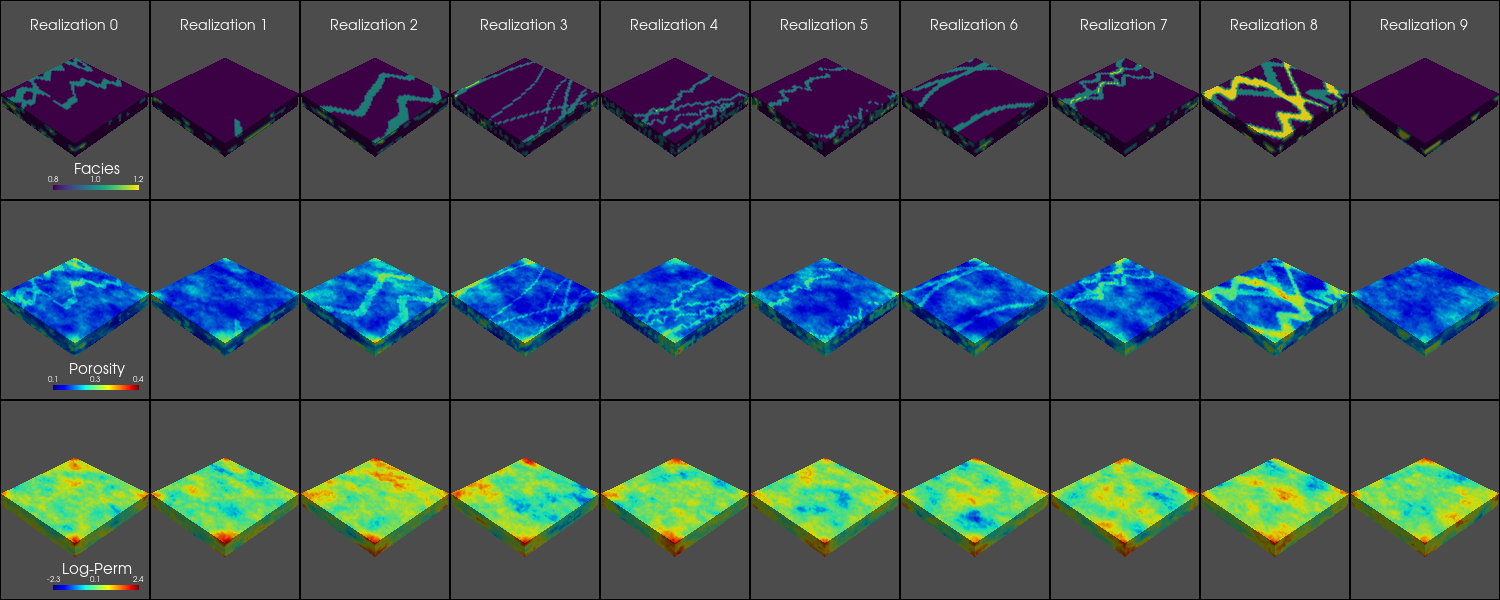

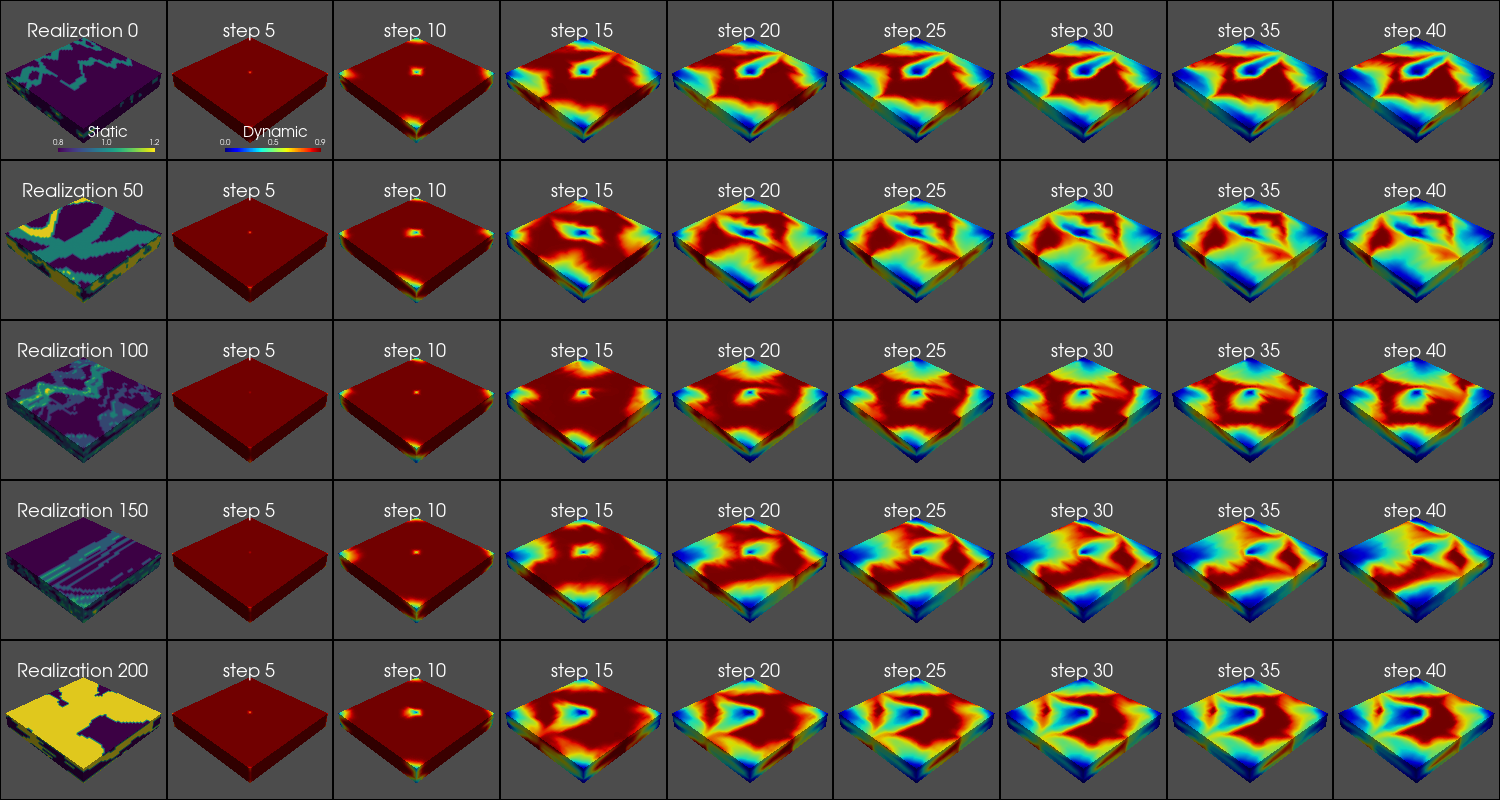

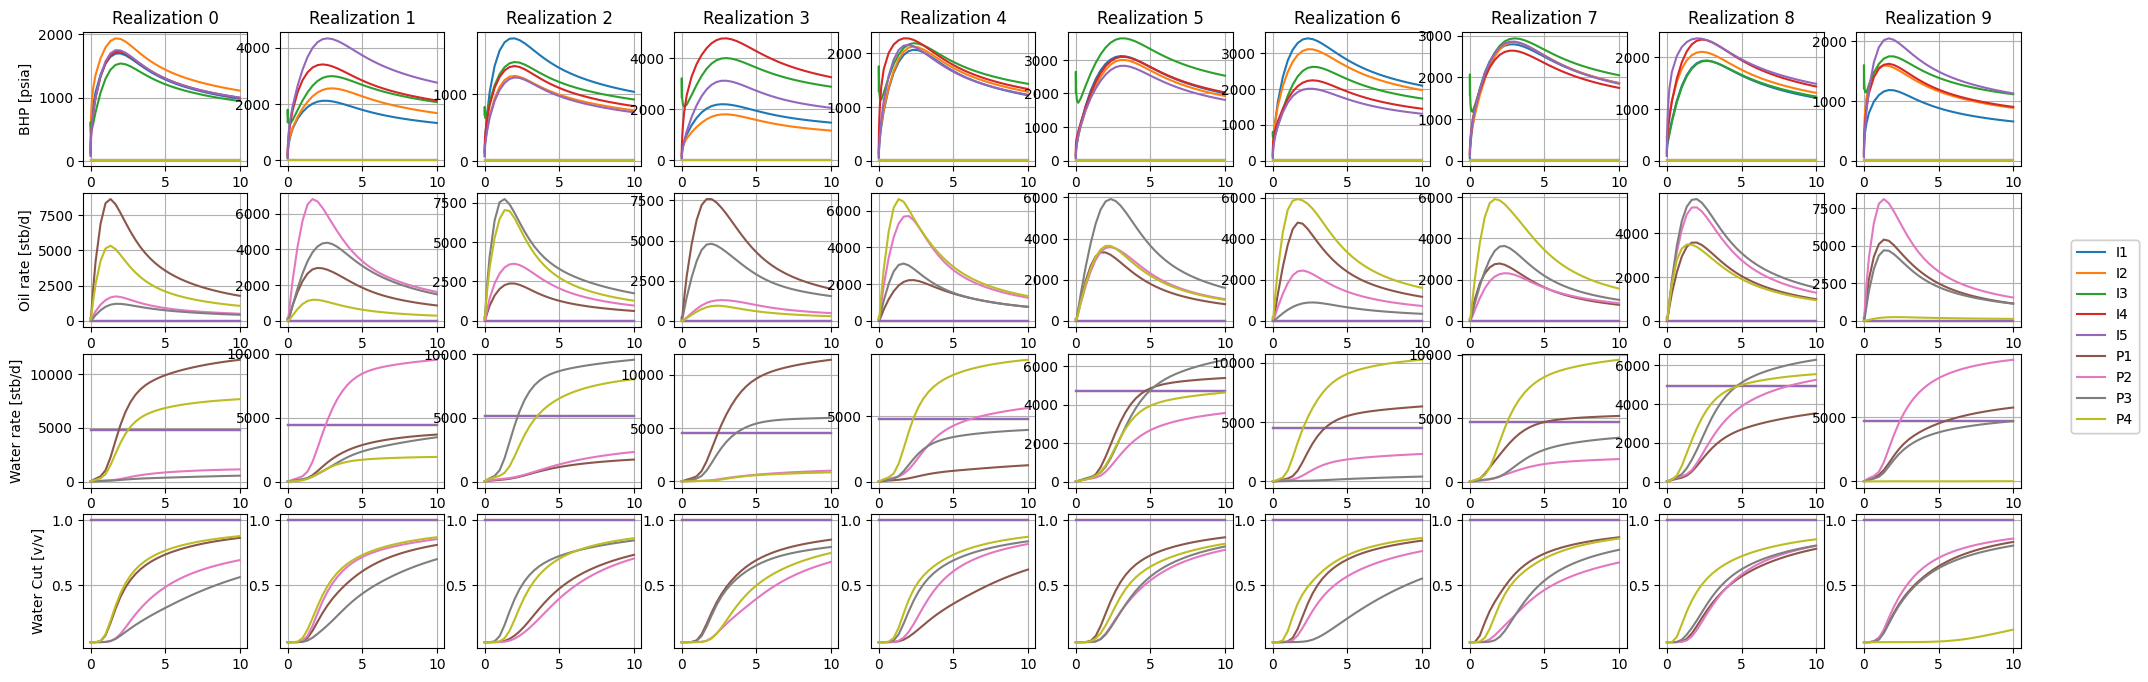

In [4]:
plot_static(facies, poro, perm)
plot_dynamic(facies, satu, multiplier=50)
plot_data(timestamps, prod)

***
# Data Processing
Load pre-existing data

Normalization, concatenate features and targets, train-test split

In [5]:
### (a) To split and normalize data into (x,y,w):
# X_data, y_data, w_data, t_data = split_xywt(facies, poro, perm, pres, satu, prod, timestamps, save=False)

### (b) To load pre-computed, normalized (X,y,w,t):
X_data, y_data, w_data, timestamps = load_xywt()

X shape: (318, 40, 48, 48, 8, 2) | y shape: (318, 48, 48, 8, 3) | w shape: (318, 40, 9, 4)
t shape: (40,)


In [6]:
# Perform train-test split
X_train, X_test, y_train, y_test, w_train, w_test, idxs, randxy = my_train_test_split(X_data, y_data, w_data)

X_train shape: (2000, 40, 30, 2) | X_test shape: (544, 40, 30, 2)
w_train shape: (2000, 40, 9, 4)  | w_test shape: (544, 40, 9, 4)
y_train shape: (2000, 48, 48, 3) | y_test shape: (544, 48, 48, 3)


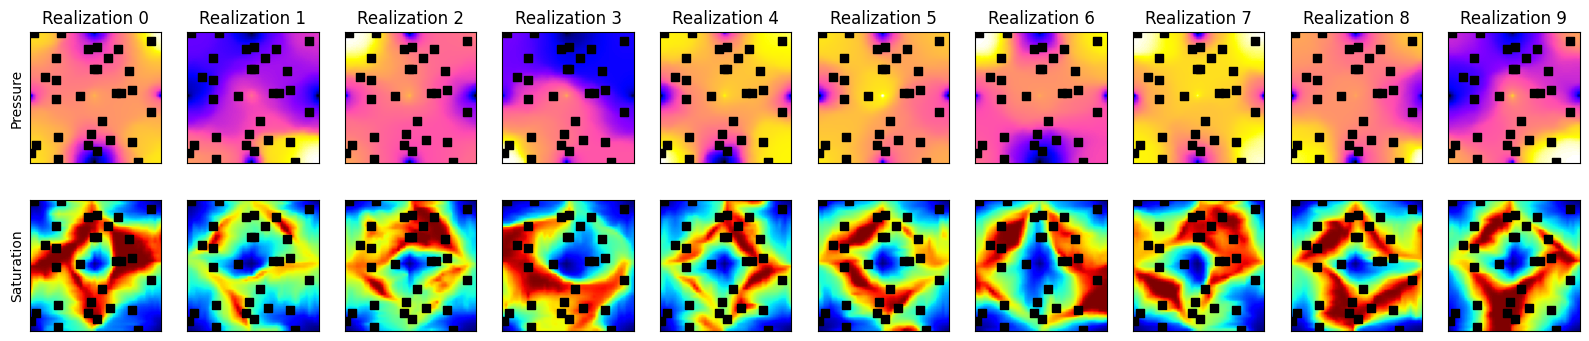

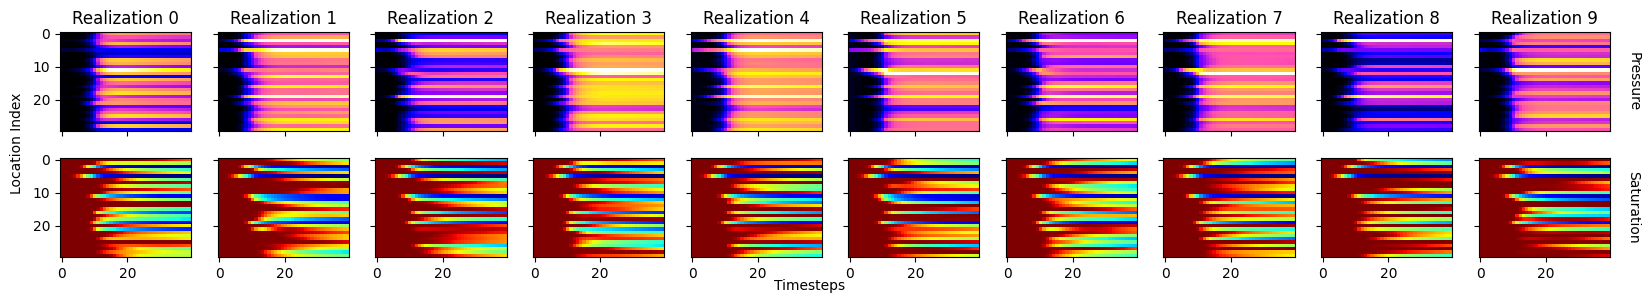

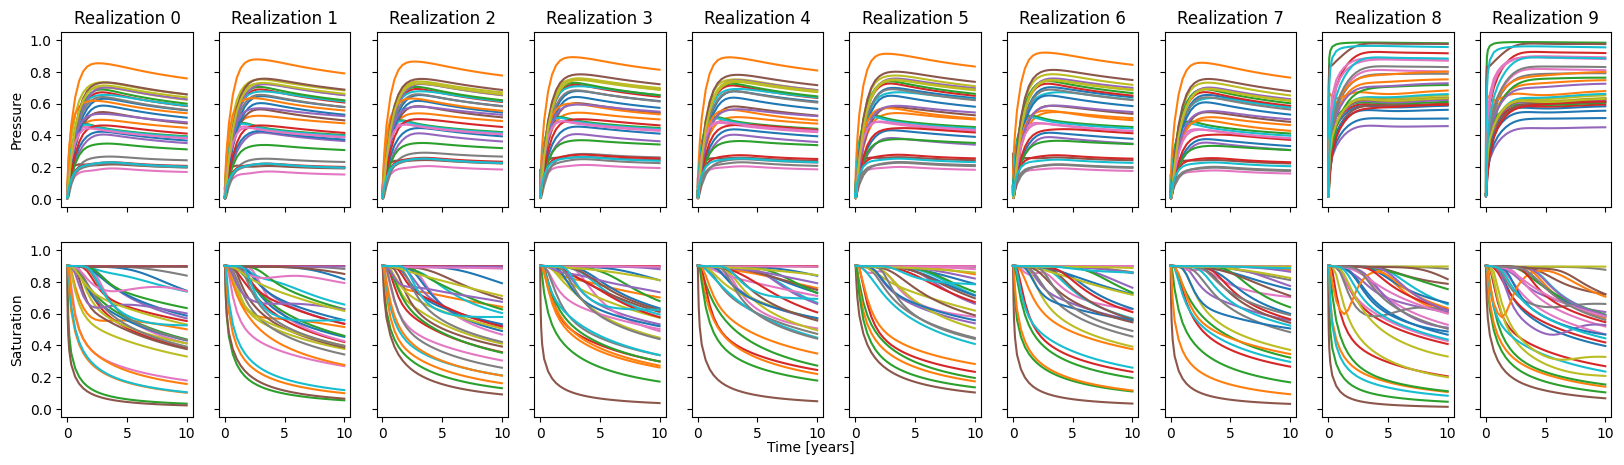

In [7]:
# Visualize X-samples
plot_X_img_observations(X_data, randxy)
plot_X_observations(X_train)
plot_X_line_observations(X_train, timestamps)

***
# Build, Compile, Train, and Predict with AutoEncoder Models
Run Train/Test Predictions

# Parameters: 930,060 | Training time: 0.45 minutes
# Parameters: 11,246 | Training time: 6.98 minutes
# Parameters: 5,021,640 | Training time: 0.78 minutes


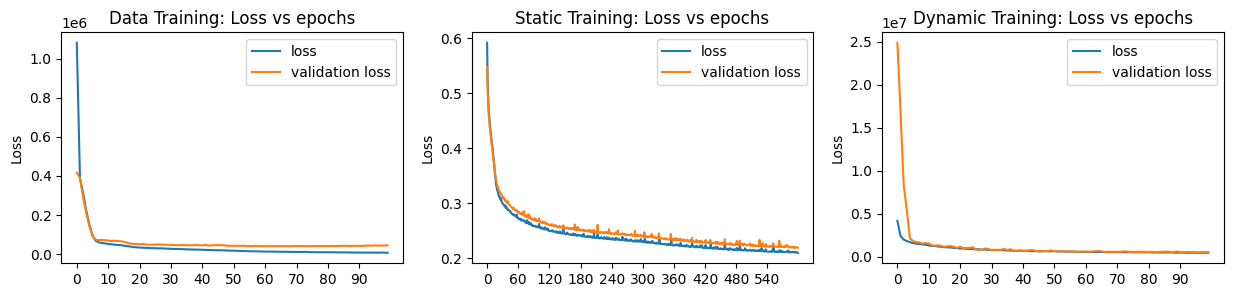

In [8]:
data_enc,    data_dec,    data_ae,    data_fit    = make_data_ae(w_train)
static_enc,  static_dec,  static_ae,  static_fit  = make_static_ae(y_train)
dynamic_enc, dynamic_dec, dynamic_ae, dynamic_fit = make_dynamic_ae(X_train)
plot_loss_all(data_fit, static_fit, dynamic_fit)

17/17 [==============================] - 0s 2ms/step
Train MSE: 5.36e-04 | Test MSE: 5.36e-04
Train SSIM: 99.43 | Test SSIM: 98.46


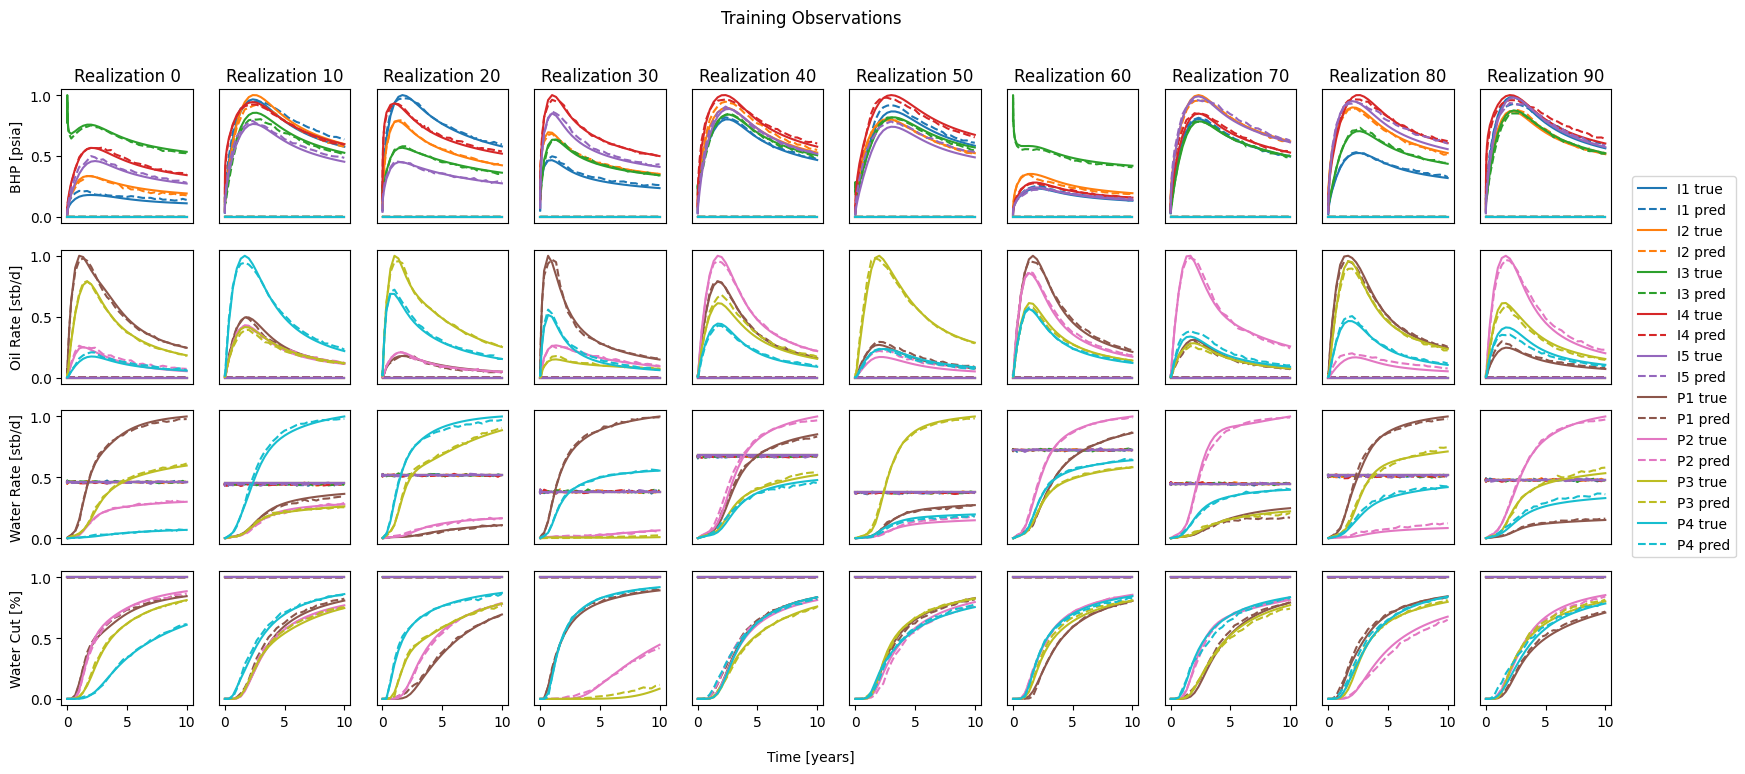

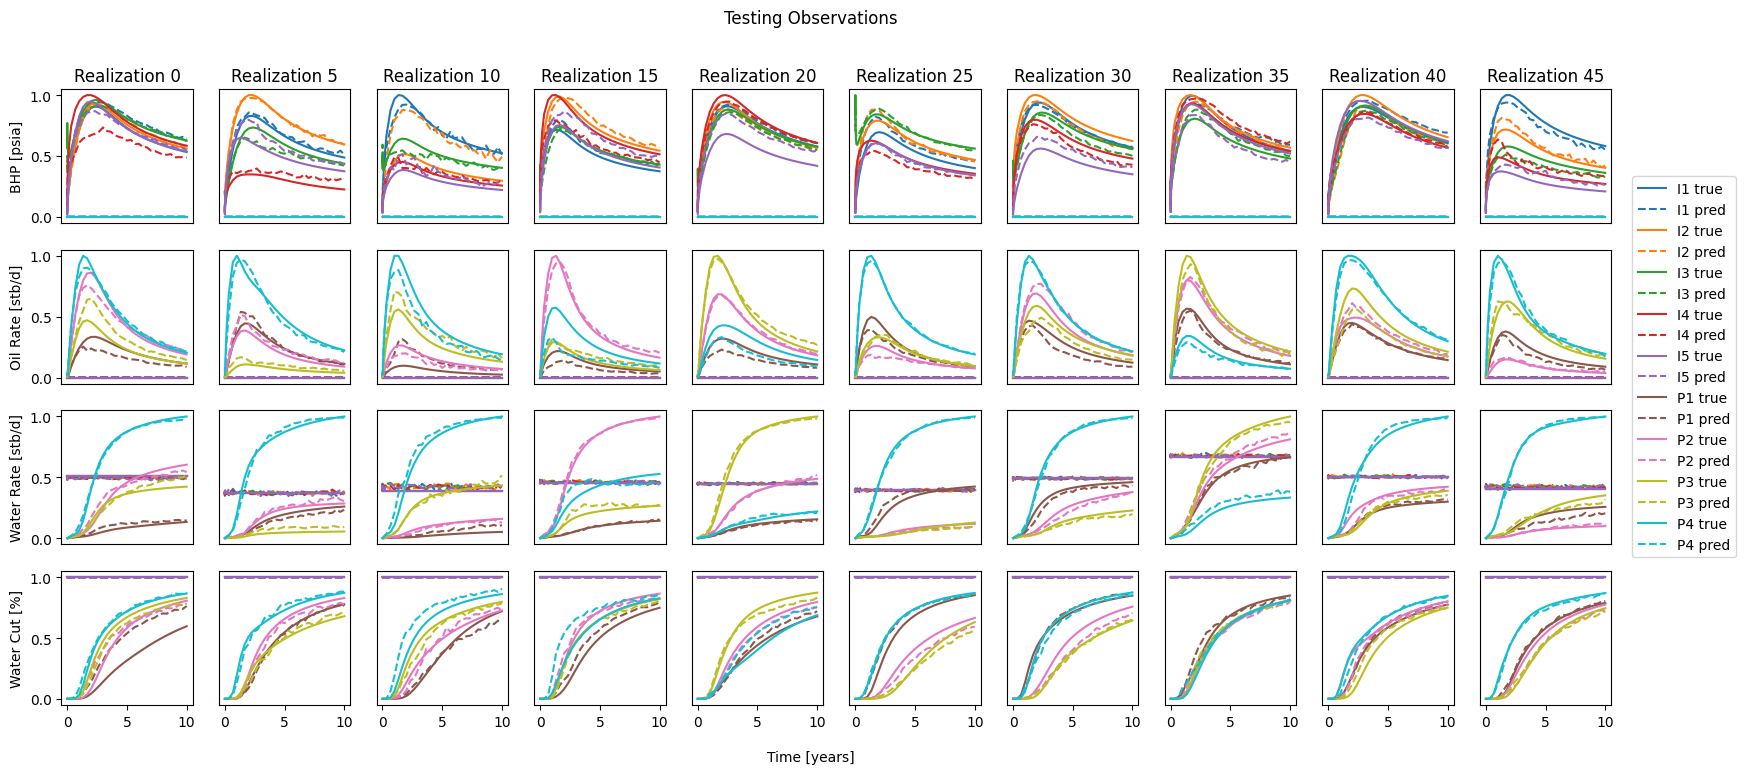

In [9]:
w_train_pred, w_test_pred = make_ae_prediction(w_train, w_test, data_ae)
plot_data_results(timestamps, w_train, w_train_pred, multiplier=10, suptitle='Training')
plot_data_results(timestamps, w_test,  w_test_pred,  multiplier=5,  suptitle='Testing')

17/17 [==============================] - 0s 7ms/step
Train MSE: 1.88e-02 | Test MSE: 1.88e-02
Train SSIM: 84.08 | Test SSIM: 82.99


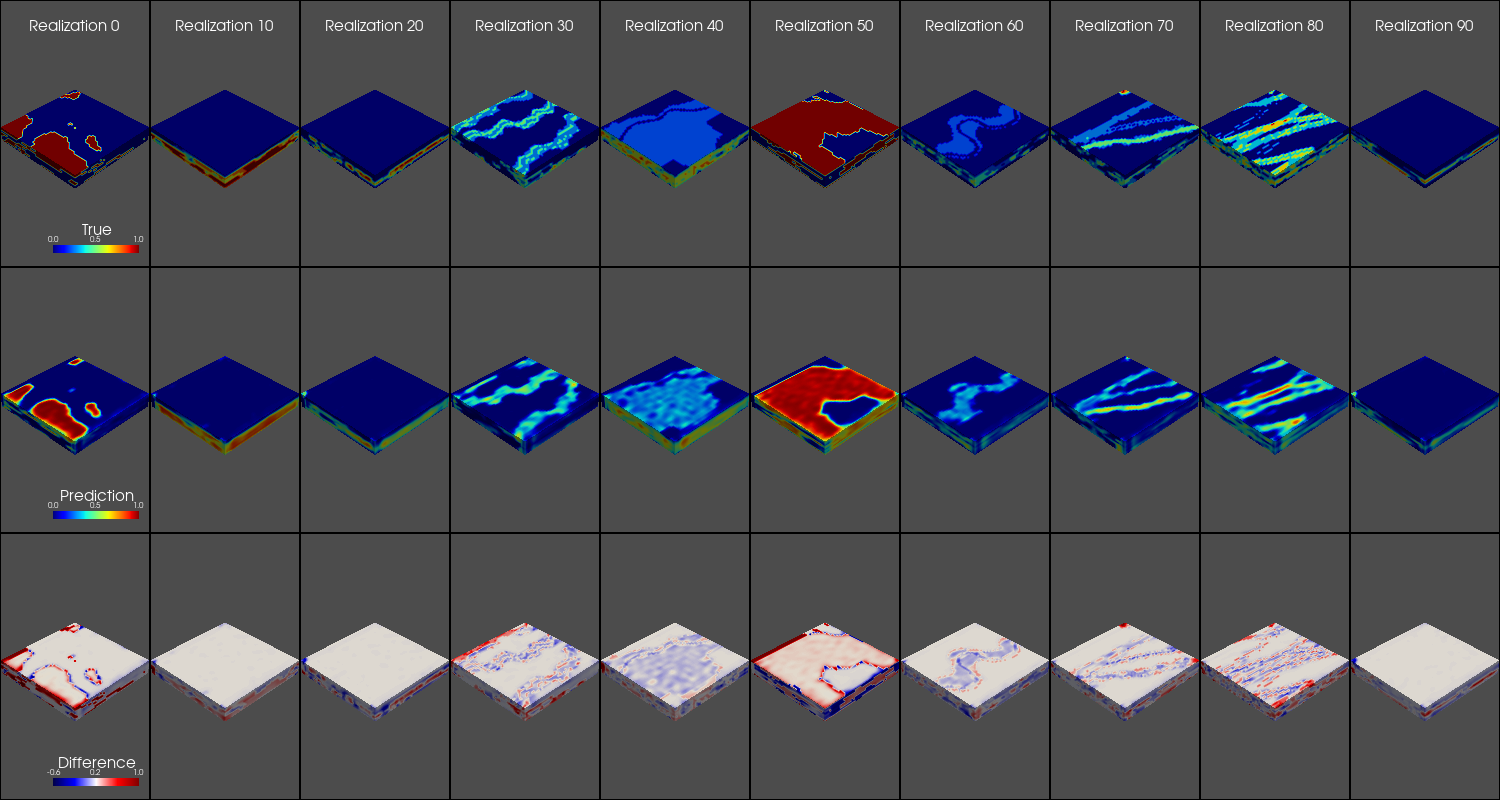

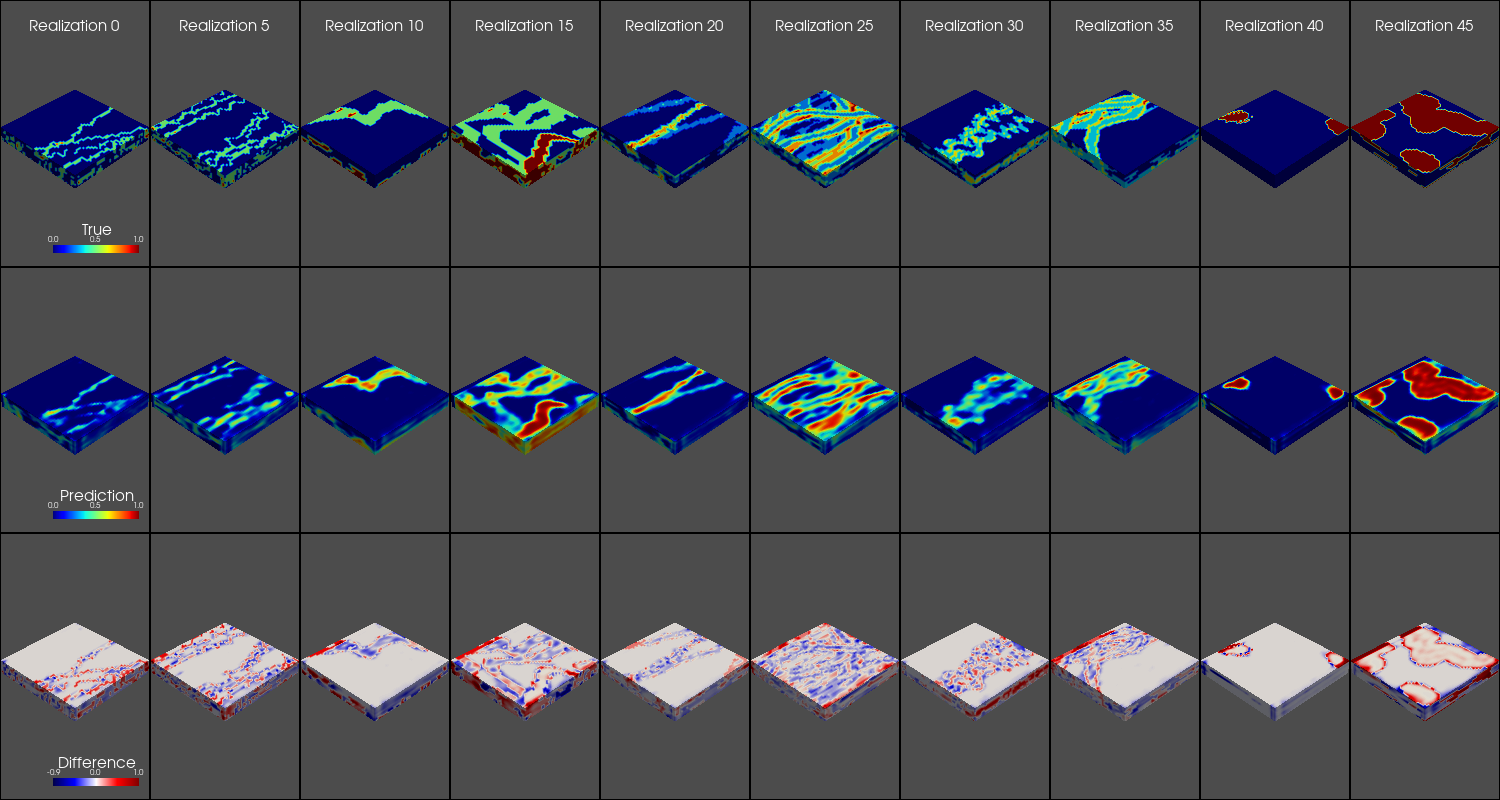

In [10]:
y_train_pred, y_test_pred = make_ae_prediction(y_train, y_test, static_ae)
plot_static_results(y_train, y_train_pred, channel_select=0, multiplier=10)
plot_static_results(y_test, y_test_pred, channel_select=0, multiplier=5)

17/17 [==============================] - 0s 4ms/step
Train MSE: 2.21e-03 | Test MSE: 2.21e-03
Train SSIM: 96.10 | Test SSIM: 93.54


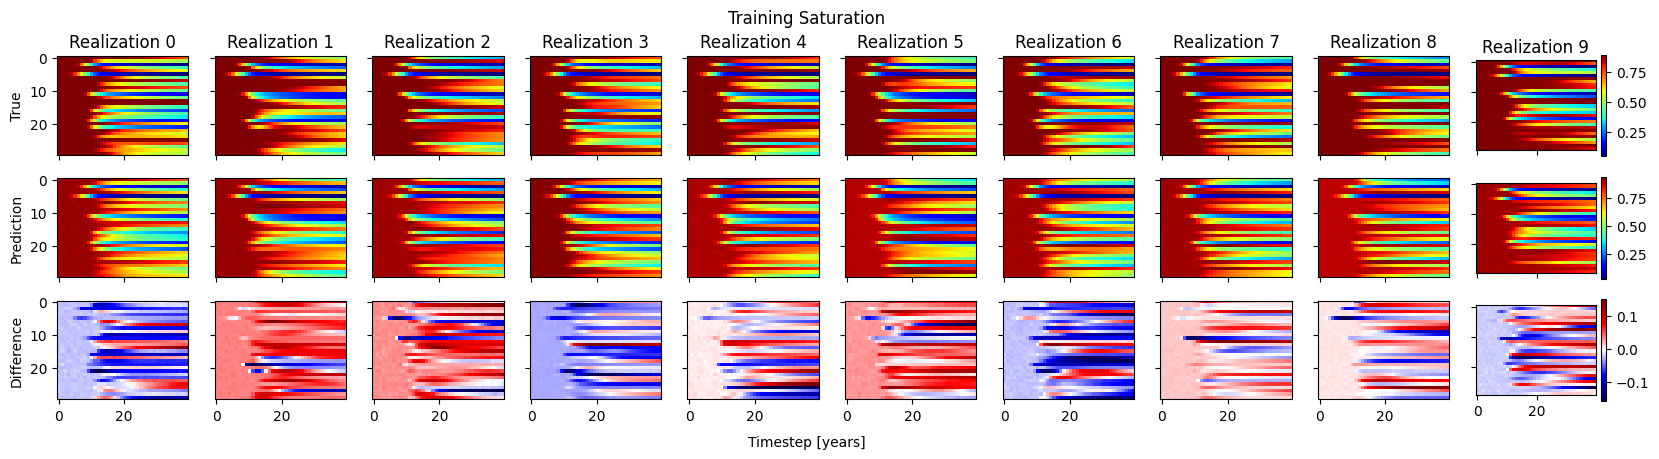

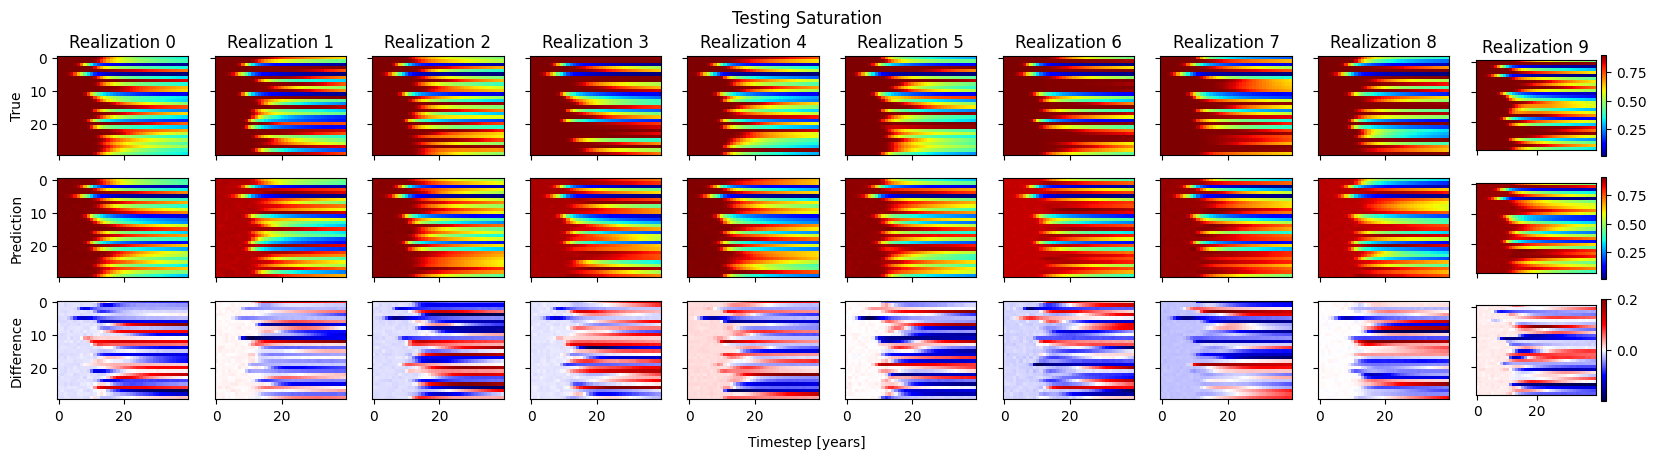

In [11]:
X_train_pred, X_test_pred = make_ae_prediction(X_train, X_test, dynamic_ae)
plot_dynamic_results(X_train, X_train_pred, channel_select=1, suptitle='Training')
plot_dynamic_results(X_test, X_test_pred, channel_select=1, suptitle='Testing')

***
# Build, Compile, Train, and Predict with Latent-Inversion Network

In [12]:
X_full, w_full, y_full = make_full_traintest(X_train, X_test, w_train, w_test, y_train, y_test)

X_full: (2544, 40, 30, 2) | w_full: (2544, 40, 9, 4) | y_full: (2544, 48, 48, 3)


# Parameters: 33,474,959 | Training time: 10.06 minutes


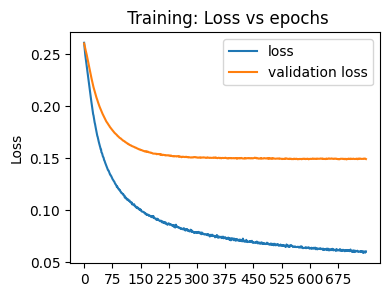

In [27]:
reg, reg_fit = make_inv_regressor(X_full, w_full, y_full, dynamic_enc, data_enc, static_dec)
plot_loss(reg_fit, figsize=(4,3))

17/17 [==============================] - 0s 10ms/step
Train MSE: 5.22e-02 | Test MSE: 1.43e-01
Train SSIM: 54.21 | Test SSIM: 12.26


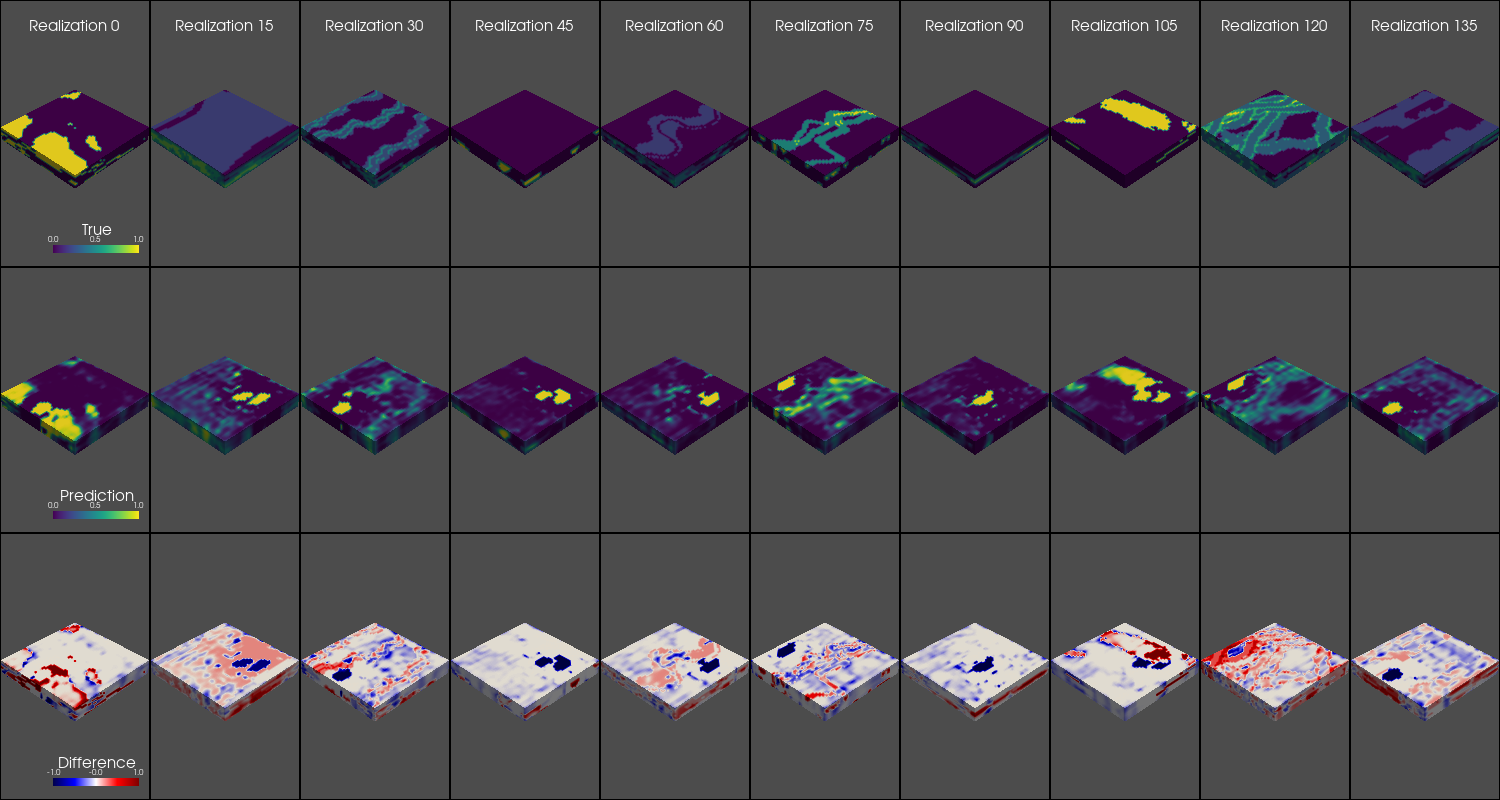

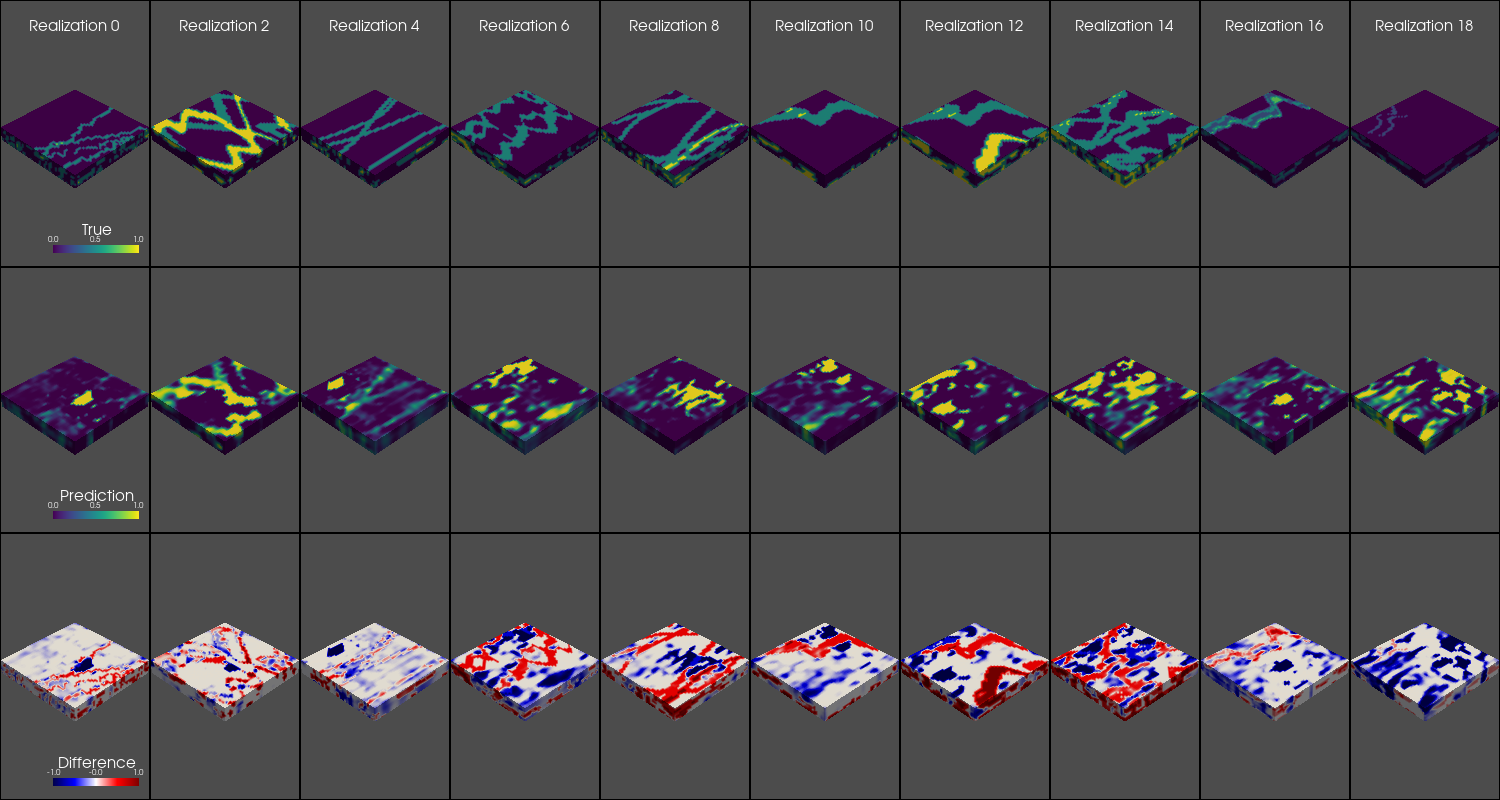

In [28]:
inv_train, inv_test = make_inv_prediction(reg, [X_train, X_test], [w_train, w_test], [y_train, y_test])
plot_static_results(y_train, inv_train, multiplier=15, channel_select=0, cmaps=['viridis','seismic'])
plot_static_results(y_test,  inv_test,  multiplier=2,  channel_select=0, cmaps=['viridis','seismic'])

***
# Back-Normalize inversion results to original domain and visualize

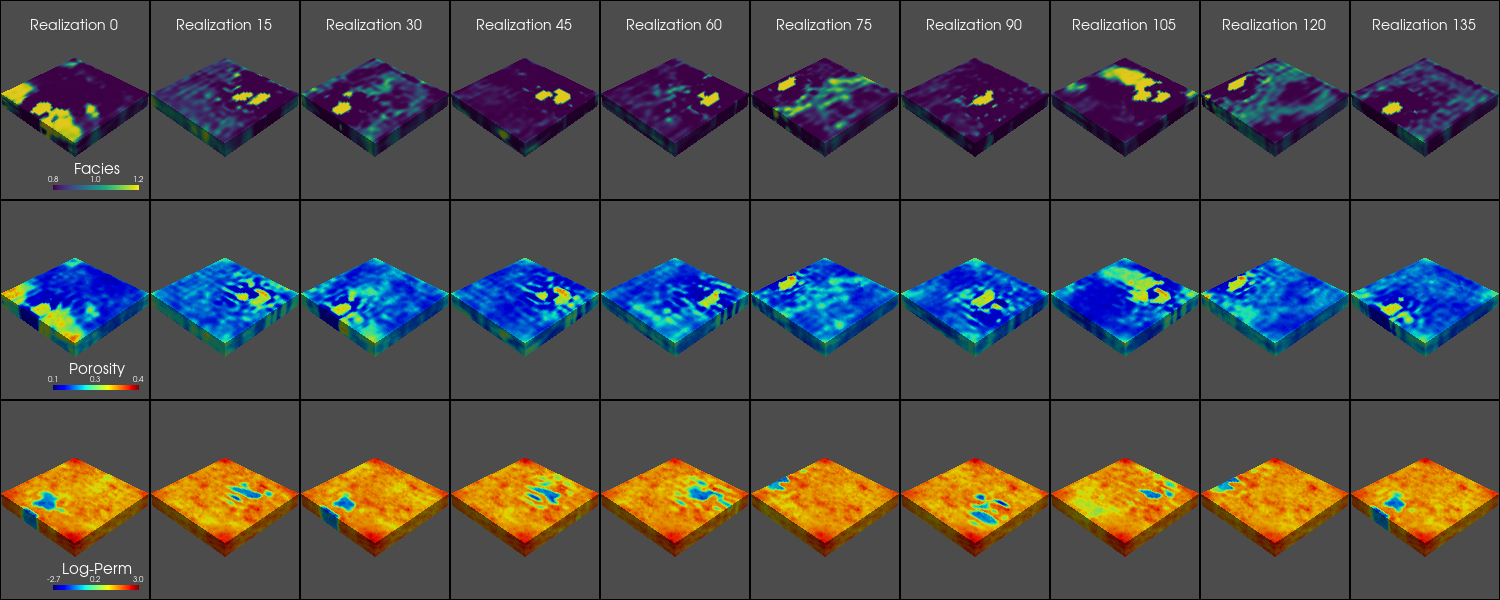

In [29]:
facies_hat, poro_hat, perm_hat = make_inv_backnorm([inv_train, inv_test], [facies, poro, perm], idxs)
plot_static(facies_hat, poro_hat, perm_hat, multiplier=15, cmaps=['viridis','jet','jet'])

***
# END